<a href="https://colab.research.google.com/github/juansebastiangit/Inteligencia_artificial/blob/main/PIRIS_PIPELINE/Materials_proyect_RAG/RAG_sample_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -q -y google-generativeai
!apt-get install -q graphviz graphviz-dev
!pip install -qU langgraph langchain langchain_google_genai pymatgen mp-api pygraphviz

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 amd64 2.24.33-2

In [ ]:
import os
from google.colab import userdata

# Load API keys from Colab secrets
os.environ["GOOGLE_API_KEY"] = userdata.get('GEMINI_API_KEY')
os.environ["MP_API_KEY"] = userdata.get('MP_API_KEY')

print("✅ API keys loaded into environment.")

✅ API keys loaded into environment.


In [ ]:
import operator
from typing import TypedDict, Annotated, Union
from langchain_core.messages import BaseMessage

class GraphState(TypedDict):
    """
    Represents the state of our agent.

    Attributes:
        user_query: The initial, unmodified query from the user.
        search_criteria: A dictionary of structured criteria for the MP API.
        search_results: A list of materials found from the API call.
        selected_material: The specific material chosen by the user.
        supercell_size: The dimensions (e.g., 2) for building the supercell.
        messages: The history of the conversation. This is the main channel for interaction.
        final_output: The final, formatted Python function to be generated.
    """
    messages: Annotated[list[BaseMessage], operator.add]
    search_results: list
    detailed_material_data: dict
    final_output: str

print("✅ Graph state defined.")

✅ Graph state defined.


In [ ]:
from dataclasses import fields
from langchain_core.tools import tool
from mp_api.client import MPRester
import json

def build_sample(unit_cell_str, atomic_positions, symmetry_operations, size):
    """
    Constructs a supercell from crystallographic data.
    (This is a placeholder for your actual supercell logic)
    """
    print(f"--- Building a {size}x{size}x{size} supercell ---")
    # In a real scenario, this function would perform complex crystallographic calculations.
    # For now, we will just format and return the input data to confirm it was received correctly.

    formatted_output = (
        f"Supercell Construction Request:\n"
        f"  - Size: {size}x{size}x{size}\n"
        f"  - Unit Cell: {unit_cell_str}\n"
        f"  - Number of Atomic Sites: {len(atomic_positions)}\n"
        f"  - Number of Symmetry Operations: {len(symmetry_operations)}\n"
        f"  - First Atom: {atomic_positions[0] if atomic_positions else 'N/A'}"
    )
    return formatted_output

@tool
def search_materials_project(formula: str = None, chemsys: str = None, material_ids: list[str] = None) -> str:
    """
    Searches the Materials Project for crystallographic data using specific criteria.
    You MUST provide at least one of the following arguments: a chemical formula (e.g., "SiO2"),
    a chemical system (e.g., "Si-O"), or a list of material IDs (e.g., ["mp-149", "mp-19017"]).
    Returns a list of matching materials as a JSON string.
    """
    if not any([formula, chemsys, material_ids]):
        return "Error: Tool called without any search criteria. Provide 'formula', 'chemsys', or 'material_ids'."

    try:
        with MPRester(api_key=os.environ["MP_API_KEY"]) as mpr:
            # CORRECTED: Using the .summary endpoint for efficient searching as per the new API docs.
            results = mpr.materials.summary.search(
                formula=formula,
                chemsys=chemsys,
                material_ids=material_ids,
                fields=["material_id", "formula_pretty", "symmetry.symbol"]
            )

            if not results:
                return "No materials found for the given criteria. Please try different search terms."
            # Convert the results to a list of dictionaries to be returned as a JSON string.
            # This is a more robust way to pass data between tools and the LLM.
            output_data = [
                {
                    "material_id": str(mat.material_id),
                    "formula_pretty": mat.formula_pretty,
                    "space_group_symbol": mat.symmetry.symbol
                }
                for mat in results [:10]
            ]

            # Return a JSON string representation of the list
            return json.dumps(output_data)

    except Exception as e:
        return f"An error occurred with the Materials Project API: {e}"
# Example of how to use the tool directly (for our testing)
#print(search_materials_project.invoke({"formula": "LiFePO4"}))

@tool
def get_material_details(material_id: str) -> str:
    """
    Retrieves the full, detailed crystallographic data for a single, specific material_id.
    Use this AFTER the user has chosen a material from the search results.
    Returns a JSON string containing the unit cell, atomic sites, and symmetry operations.
    """
    print(f"--- Fetching details for Material ID: {material_id} ---")
    try:
        with MPRester(api_key=os.environ["MP_API_KEY"]) as mpr:
            # We search for the full document, not just the summary
            material_doc = mpr.materials.summary.search(material_ids=[material_id])[0]

            # Extract the necessary data for building a supercell
            structure = material_doc.structure
            unit_cell_params = structure.lattice.parameters
            unit_cell_str = f"a={unit_cell_params[0]:.3f}, b={unit_cell_params[1]:.3f}, c={unit_cell_params[2]:.3f}, alpha={unit_cell_params[3]:.2f}, beta={unit_cell_params[4]:.2f}, gamma={unit_cell_params[5]:.2f}"

            atomic_sites = [{"element": str(site.specie), "x": site.a, "y": site.b, "z": site.c} for site in structure.sites]

            # Note: Symmetry operations are complex. For now, we'll just note the space group symbol.
            # Your final `build_sample` would need the full symmetry operations matrices.
            symmetry = {"symbol": material_doc.symmetry.symbol, "number": material_doc.symmetry.number}

            detailed_data = {
                "material_id": str(material_id),
                "formula": material_doc.formula_pretty,
                "unit_cell": unit_cell_str,
                "atomic_sites": atomic_sites,
                "symmetry": symmetry
            }
            return json.dumps(detailed_data)
    except Exception as e:
        return f"An error occurred while fetching details for {material_id}: {e}"

@tool
def build_supercell(material_data_json: str, size: int) -> str:
    """
    Constructs a supercell from detailed crystallographic data.
    This is the final step. Call this only after you have used 'get_material_details'
    to retrieve the full data for a material the user has selected.

    Args:
        material_data_json: A JSON string containing the detailed material data from 'get_material_details'.
        size: An integer representing the supercell dimensions (e.g., 2 for a 2x2x2 supercell).
    """
    try:
        data = json.loads(material_data_json)
        # Assuming your build_sample function can be adapted to take these inputs
        return build_sample(
            unit_cell_str=data["unit_cell"],
            atomic_positions=data["atomic_sites"],
            symmetry_operations=[data["symmetry"]], # Placeholder for full symmetry ops
            size=size
        )
    except Exception as e:
        return f"Error building supercell: {e}"

print("✅ All agent tools defined.")

✅ All agent tools defined.


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

tools = tools = [search_materials_project, get_material_details, build_supercell]
llm_with_tools = llm.bind_tools(tools)


print("✅ LLM initialized and bound to all tools.")

✅ LLM initialized and bound to all tools.


In [ ]:
from langchain_core.messages import ToolMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode

# We will create a dictionary that maps the tool names to their callable functions.
# This makes it easy to find and run the correct tool.
tool_node = ToolNode(tools)

# 1. The "Thinker" Node: This runs the LLM to decide the next action. (Unchanged)
def call_model(state: GraphState):
    """Invokes the LLM with the current conversation state."""
    print("---NODE: AGENT (Thinking)---")
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Node 2: A helper node to parse the tool's JSON output and update the state.
def handle_search_results(state: GraphState):
    """Parses the JSON output from the search tool and stores it in the state."""
    print("---NODE: PARSE SEARCH RESULTS---")
    last_message = state["messages"][-1]

    # The tool output is a JSON string in the 'content' of the ToolMessage.
    tool_output_str = last_message.content

    try:
        # Attempt to parse the JSON string.
        search_results = json.loads(tool_output_str)
        print(f"Successfully parsed {len(search_results)} results.")
        return {"search_results": search_results}
    except (json.JSONDecodeError, TypeError):
        # If the tool returned an error message (not JSON), we'll have an empty list.
        print("No valid JSON results found.")
        return {"search_results": []}

# Node 3: Detailed Results Parser
def handle_detail_results(state: GraphState):
    """Parses the JSON from get_material_details and stores it."""
    print("---NODE: PARSE DETAIL RESULTS---")
    last_message = state["messages"][-1]
    tool_output_str = last_message.content
    try:
        # This tool returns a single dictionary, not a list
        detailed_data = json.loads(tool_output_str)
        return {"detailed_material_data": detailed_data}
    except (json.JSONDecodeError, TypeError) as e:
        print(f"Error parsing detail results: {e}")
        # Return an error message to the user
        error_message = AIMessage(content=f"I'm sorry, I couldn't process the details for that material. The tool returned: {tool_output_str}")
        return {"messages": [error_message]}

# Node 4: Asks the user to choose from multiple results.
def present_search_options(state: GraphState):
    """Formats multiple search results and asks the user to choose one."""
    print("---NODE: PRESENT OPTIONS---")
    search_results = state["search_results"]

    # Create a formatted message with a numbered list of options.
    options = []
    for i, material in enumerate(search_results):
        options.append(f"{i+1}. {material['formula_pretty']} (ID: {material['material_id']})")

    message_content = "I found several materials. Please choose one by number:\n" + "\n".join(options)

    # Add this message to the conversation history to be shown to the user.
    return {"messages": [AIMessage(content=message_content)]}

# Node 5: Asks the user for a better query when no results are found.
def request_clarification(state: GraphState):
    """Asks the user to rephrase their query when no results are found."""
    print("---NODE: REQUEST CLARIFICATION---")
    message_content = "I couldn't find any materials matching your query. Could you please provide a different chemical formula or system?"
    return {"messages": [AIMessage(content=message_content)]}

# Node 6: Asks the user what to do after finding a material.
def summarize_and_prompt_next(state: GraphState):
    """
    Summarizes the found material and asks the user for the next step.
    """
    print("---NODE: SUMMARIZE AND PROMPT NEXT---")
    material_formula = state["detailed_material_data"].get("formula", "the selected material")
    space_group = state["detailed_material_data"].get("symmetry", {}).get("symbol", "N/A")

    message_content = (
        f"I have the details for {material_formula} (space group: {space_group}). "
        "What would you like to do next? You can ask me to:\n"
        "1. **Build a supercell** (e.g., 'build a 2x2x2 cell')\n"
        "2. **Show the full details**"
    )
    return {"messages": [AIMessage(content=message_content)]}

# Node 7: Prepares data from the state and calls the build_supercell tool.
def prepare_and_build_supercell(state: GraphState):
    """
    A state-aware node that prepares the arguments for the build_supercell tool
    by pulling data directly from the GraphState.
    """
    print("---NODE: PREPARE AND BUILD SUPERCELL---")

    # The LLM's decision to call the tool, including the 'size' argument
    last_ai_message = state["messages"][-1]
    tool_call = last_ai_message.tool_calls[0]
    size = tool_call['args']['size']

    # The detailed material data we stored earlier
    detailed_data = state["detailed_material_data"]
    material_data_json = json.dumps(detailed_data)

    print(f"Size: {size}")
    print(f"Material Data JSON (from state): {material_data_json[:100]}...") # Print first 100 chars

    # Call the actual tool with the correct arguments
    result = build_supercell.invoke({
        "material_data_json": material_data_json,
        "size": size
    })

    # Create a ToolMessage to store the result, maintaining the conversation flow
    tool_message = ToolMessage(content=str(result), tool_call_id=tool_call['id'])

    return {"messages": [tool_message]}

# Node 8: Displays the formatted material details from the state.
def inject_details_context(state: GraphState):
    """
    Takes the detailed material data from the state and adds it to the message
    history as context for the LLM to use in its next turn.
    """
    print("---NODE: INJECT DETAILS CONTEXT---")
    detailed_data = state["detailed_material_data"]

    # Create a context message string
    context_message_content = (
        "CONTEXT: The user has asked to see the details. "
        "Please format the following detailed material data into a clear, "
        "human-readable response for the user. Do not mention that you have already provided it. "
        "After presenting the details, ask what to do next, and be sure to mention they can type 'exit' to end the conversation. "
        f"Data: {json.dumps(detailed_data)}"
    )

    # Add this as a new HumanMessage. This is a clean way to provide context.
    context_message = HumanMessage(content=context_message_content)

    return {"messages": [context_message]}

# Node 9: Final Output Node
def handle_final_output(state: GraphState):
    """Presents the final output or a graceful error message."""
    print("---NODE: HANDLE FINAL OUTPUT---")
    last_message = state["messages"][-1]
    final_output_str = last_message.content

    # Check if the tool returned an error string
    if final_output_str.lower().startswith("error"):
        message_content = f"I'm sorry, I encountered an issue: {final_output_str}. This might be a problem with the data from the API. Would you like to try a different material?"
        message = AIMessage(content=message_content)
    else:
        # Append a follow-up prompt to the success message.
        success_content = (
            f"Here is the result:\n\n```\n{final_output_str}\n```\n\n"
            "What would you like to do next? You can search for another material or type 'exit' to end the conversation."
        )
        message = AIMessage(content=success_content)

    return {"messages": [message], "final_output": final_output_str}

print("✅ Agent nodes defined and ready.")

✅ Agent nodes defined and ready.


In [ ]:
# -------Routers------
# Router 1: Decides if we need to call a tool after the LLM thinks, and which tool to call.
def route_after_agent(state: GraphState):
    print("---ROUTER: After Agent---")
    last_message = state["messages"][-1]

    if last_message.tool_calls:
        tool_name = last_message.tool_calls[0]['name']
        print(f"Decision: Call tool '{tool_name}'")
        if tool_name == "build_supercell":
            return "prepare_and_build_supercell"
        else: # For search_materials_project or get_material_details
            return "action"

    # Now, check the user's intent from the *previous* turn.
    # The second to last message is the user's input that led to the agent's current response.
    if len(state["messages"]) > 1:
        user_message = state["messages"][-2]
        # We only want to inject context if the USER just asked for details.
        # We check if the last message from our side was the prompt for the next step.
        if isinstance(user_message, HumanMessage) and any(keyword in user_message.content.lower() for keyword in ["show", "display", "details"]):
             # Let's also check that we haven't ALREADY injected context in the last turn.
             if "CONTEXT:" not in user_message.content:
                print("Decision: User wants to see details. Injecting context.")
                return "inject_details_context"

    print("Decision: No tool call, end of turn.")
    return "end"

# Router 2: Decides where to go AFTER a tool has been called.
def route_after_generic_tool(state: GraphState):
    print("---ROUTER: After Generic Tool Call---")

    last_message = state["messages"][-1]

    # The tool call could be in the second to last message
    tool_call_message = None
    if len(state["messages"]) > 1:
        second_last_message = state["messages"][-2]
        if isinstance(second_last_message, AIMessage) and second_last_message.tool_calls:
            tool_call_message = second_last_message

    # If not found, it's an issue, but we can handle it gracefully.
    if not tool_call_message:
        # Fallback or error handling
        print("Error: Could not find the tool call message.")
        return END

    tool_name = tool_call_message.tool_calls[0]['name']
    print(f"Tool called: {tool_name}")

    if tool_name == "search_materials_project":
        return "handle_search_results"
    elif tool_name == "get_material_details":
        return "handle_detail_results"
    else:
        return END

# Router 3: Decides what to do after we have processed the search results.
def route_after_search(state: GraphState):
    print("---ROUTER: After Search---")
    search_results = state["search_results"]

    if not search_results:
        print("Decision: No results found, requesting clarification.")
        return "request_clarification"
    elif len(search_results) == 1:
        print("Decision: One result found, summarizing.")
        return "agent" # Loop back to the agent to summarize the single result.
    else:
        print("Decision: Multiple results found, presenting options.")
        return "present_search_options"

# --- GRAPH CONSTRUCTION ---

# Initialize
builder = StateGraph(GraphState)

# Add the nodes to the graph
builder.add_node("agent", call_model)
# We add our pre-built ToolNode directly to the graph.
builder.add_node("action", tool_node)
# Add the node for parsing query search results
builder.add_node("handle_search_results", handle_search_results)
# Add node for detailed query
builder.add_node("handle_detail_results", handle_detail_results)
# Add context-injection node
builder.add_node("inject_details_context", inject_details_context)
# Add node for summarizing detailed info and asking for next step
builder.add_node("summarize_and_prompt_next", summarize_and_prompt_next)
# Add node for showing result to the user
builder.add_node("present_search_options", present_search_options)
# Add node for search parameter clarifications
builder.add_node("request_clarification", request_clarification)
# Add node for state aweareness context
builder.add_node("prepare_and_build_supercell", prepare_and_build_supercell)
# Add node for handling final answer
builder.add_node("handle_final_output", handle_final_output)


# Set the entry point
builder.set_entry_point("agent")

# Wire the graph
builder.add_conditional_edges("agent", route_after_agent, {
    "action": "action",
    "prepare_and_build_supercell": "prepare_and_build_supercell",
    "inject_details_context": "inject_details_context",
    "end": END
})

builder.add_conditional_edges(
    "action",
    route_after_generic_tool,
    {
        "handle_search_results": "handle_search_results",
        "handle_detail_results": "handle_detail_results",
        END: END
    }
)
builder.add_conditional_edges(
    "handle_search_results",
    route_after_search,
    {
        "request_clarification": "request_clarification",
        "present_search_options": "present_search_options",
        "agent": "agent"
    }
)
builder.add_edge("handle_detail_results", "summarize_and_prompt_next")
builder.add_edge("inject_details_context", "agent")
builder.add_edge("prepare_and_build_supercell", "handle_final_output")
builder.add_edge("present_search_options", END)
builder.add_edge("request_clarification", END)
builder.add_edge("handle_final_output", END)
builder.add_edge("summarize_and_prompt_next", END)

# Compile the graph
app = builder.compile()

print("✅ LangGraph compiled successfully with the correct tool node!")

✅ LangGraph compiled successfully with the correct tool node!


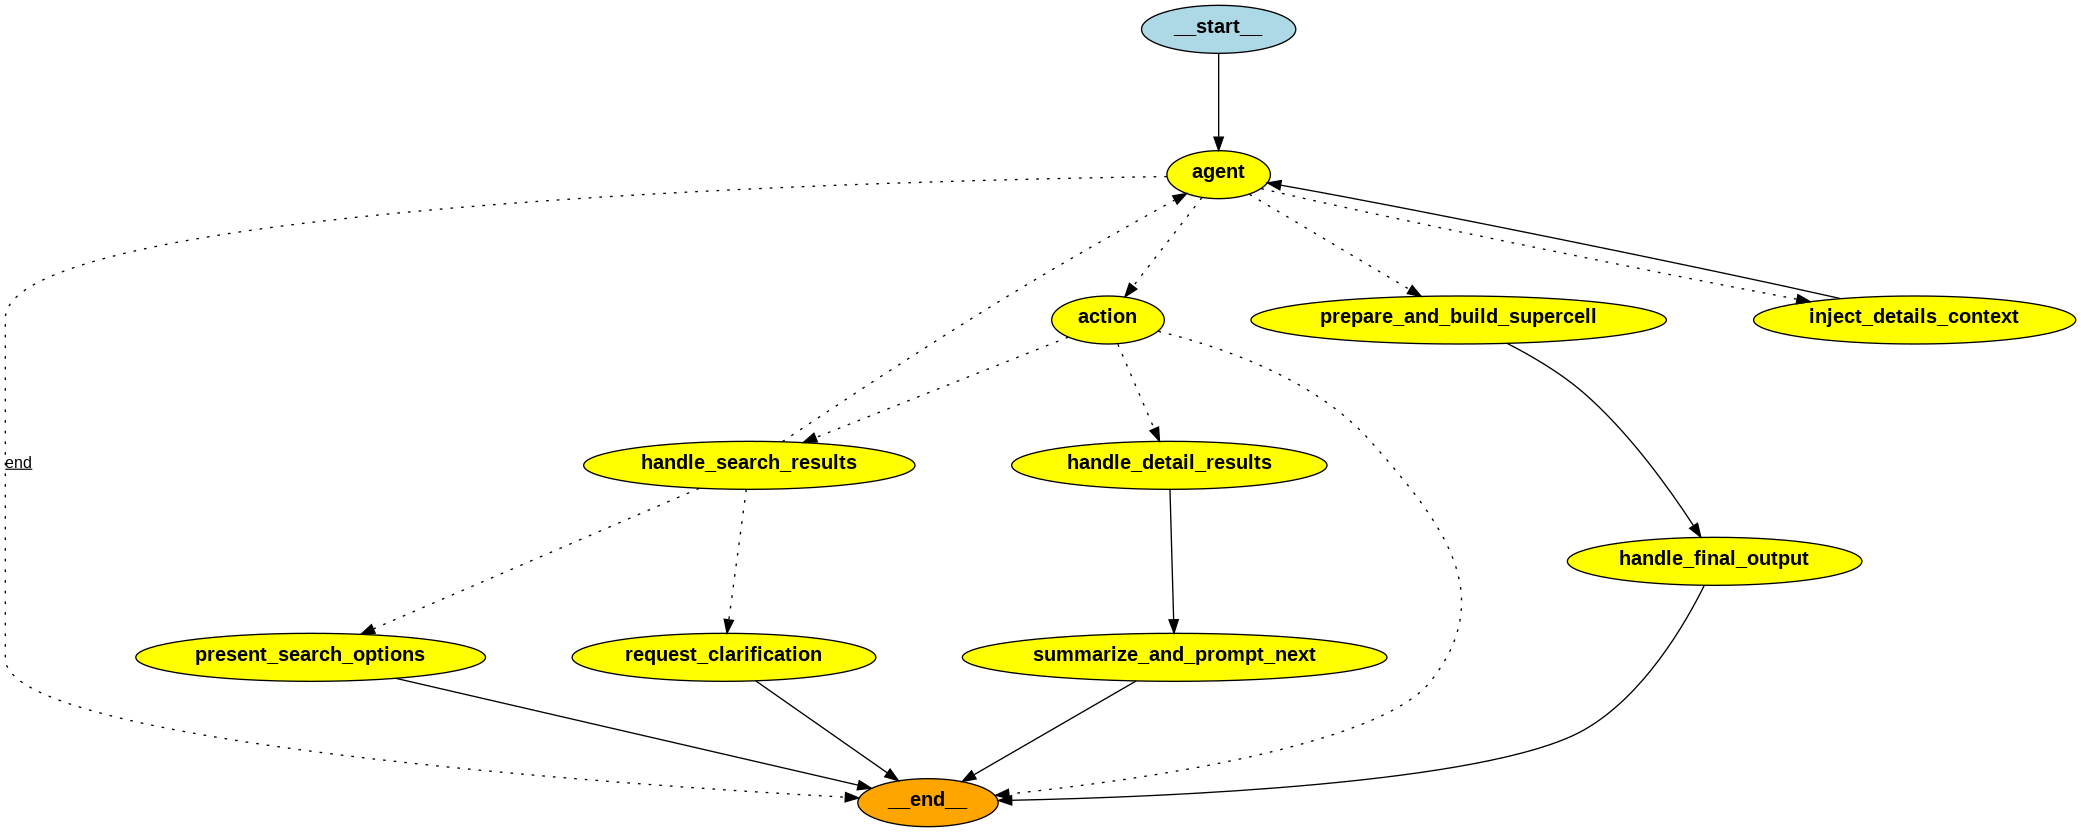

In [ ]:
from IPython.display import Image

# Now we can generate the visualization. The .get_graph() method provides access
# to the graph's structure, and .draw_png() renders it as a PNG image.
graph_image = app.get_graph().draw_png()

# Display the image in the notebook output.
Image(graph_image)

In [ ]:
import pprint

# --- We will manage the full state of the conversation here ---
conversation_state = GraphState(
    messages=[],
    search_results=[],
    detailed_material_data={}, # Initialize with an empty dictionary
    final_output="" # Initialize with an empty string
)

print("--- Agent is ready. Type 'exit' to end the conversation. ---\n")

while True:
    try:
        user_input = input("You: ")
        if user_input.lower() == 'exit':
            print("--- Conversation ended. ---\n")
            break

        # Add the user's message to the state's message list
        conversation_state['messages'].append(HumanMessage(content=user_input))

        # Invoke the agent with the entire, persistent state object
        config = {"recursion_limit": 50}

        # The 'response_state' is the complete, updated state after the agent's turn.
        response_state = app.invoke(conversation_state, config=config)

        # The agent's display message is the last one in the list.
        agent_response_message = response_state['messages'][-1]

        # IMPORTANT: Update our loop's state with the new state from the agent run.
        conversation_state = response_state

        print(f"Agent: {agent_response_message.content}")

        # Check for unrecoverable errors to end the conversation
        if "error" in agent_response_message.content.lower() or "i'm sorry, i couldn't" in agent_response_message.content.lower():
            if response_state.get('final_output') and "error" in response_state['final_output'].lower():
                 print("--- Agent reported an unrecoverable error. Ending conversation. ---\n")
                 break

    except Exception as e:
        print(f"An error occurred: {e}")
        break

--- Agent is ready. Type 'exit' to end the conversation. ---

You: oxigeno
---NODE: AGENT (Thinking)---
---ROUTER: After Agent---
Decision: No tool call, end of turn.
Agent: It seems you're asking about oxygen. To help me find the correct materials, could you please provide a chemical formula (e.g., O2), a chemical system (e.g., O), or a Materials Project ID (e.g., mp-149)?
You: solo oxigeno
---NODE: AGENT (Thinking)---
---ROUTER: After Agent---
Decision: Call tool 'search_materials_project'


Retrieving SummaryDoc documents:   0%|          | 0/28 [00:00<?, ?it/s]

---ROUTER: After Generic Tool Call---
Tool called: search_materials_project
---NODE: PARSE SEARCH RESULTS---
Successfully parsed 10 results.
---ROUTER: After Search---
Decision: Multiple results found, presenting options.
---NODE: PRESENT OPTIONS---
Agent: I found several materials. Please choose one by number:
1. O2 (ID: mp-1009490)
2. O2 (ID: mp-1023923)
3. O2 (ID: mp-1056059)
4. O2 (ID: mp-1056831)
5. O2 (ID: mp-1057818)
6. O2 (ID: mp-1058623)
7. O2 (ID: mp-1065697)
8. O2 (ID: mp-1066100)
9. O2 (ID: mp-1087546)
10. O2 (ID: mp-1102442)
You: quiero el 4 y el 10
---NODE: AGENT (Thinking)---
---ROUTER: After Agent---
Decision: Call tool 'get_material_details'
--- Fetching details for Material ID: mp-1056831 ---
--- Fetching details for Material ID: mp-1102442 ---


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

---ROUTER: After Generic Tool Call---
Error: Could not find the tool call message.
Agent: {"material_id": "mp-1102442", "formula": "O2", "unit_cell": "a=4.706, b=4.706, c=4.989, alpha=90.00, beta=90.00, gamma=90.00", "atomic_sites": [{"element": "O", "x": 0.595569, "y": 0.264971, "z": 0.507116999999999}, {"element": "O", "x": 0.404431, "y": 0.735028999999999, "z": 0.007117}, {"element": "O", "x": 0.764971, "y": 0.904431, "z": 0.257117}, {"element": "O", "x": 0.235029, "y": 0.095569, "z": 0.757116999999999}, {"element": "O", "x": 0.735028999999999, "y": 0.404431, "z": 0.992883}, {"element": "O", "x": 0.264971, "y": 0.595569, "z": 0.492882999999999}, {"element": "O", "x": 0.904431, "y": 0.764971, "z": 0.742883}, {"element": "O", "x": 0.095569, "y": 0.235029, "z": 0.242883}, {"element": "O", "x": 0.96935, "y": 0.030650000000000004, "z": 0.75}, {"element": "O", "x": 0.030650000000000004, "y": 0.96935, "z": 0.25}, {"element": "O", "x": 0.5306500000000001, "y": 0.5306500000000001, "z": 0.5},

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

---ROUTER: After Generic Tool Call---
Tool called: get_material_details
---NODE: PARSE DETAIL RESULTS---
---NODE: SUMMARIZE AND PROMPT NEXT---
Agent: I have the details for O2 (space group: P2/m). What would you like to do next? You can ask me to:
1. **Build a supercell** (e.g., 'build a 2x2x2 cell')
2. **Show the full details**
You: detalles
---NODE: AGENT (Thinking)---
---ROUTER: After Agent---
Decision: No tool call, end of turn.
Agent: Okay, here are the details for material ID mp-1056831:

*   **Formula:** O2
*   **Material ID:** mp-1056831
*   **Symmetry:**
    *   Number: 10
    *   Symbol: P2/m
*   **Unit Cell:**
    *   a: 1.520 Angstroms
    *   b: 3.096 Angstroms
    *   c: 4.714 Angstroms
    *   alpha: 77.36 degrees
    *   beta: 90.00 degrees
    *   gamma: 90.00 degrees
*   **Atomic Sites:**
    *   Element: O
    *   x: 0.5
    *   y: 0
    *   z: 0.5
You: a ver hagamos una muestra de 5
---NODE: AGENT (Thinking)---
---ROUTER: After Agent---
Decision: Call tool 'build_su

1. Reintentar la parte de mostrar diferentes resultados de busqueda y tratar de hacerla más dinamica.

2. implementar buscar detalles para multiples materiales y poder compararlos

3. Estaria bien que el agente pueda deterimanr diferentes mensajes de "adios" para terminar el loop, aunque esto lo maneja el while y es mucho mas rigido

3. la funcion de cosntruccion necesita MUCHOS cambios JAJAJA
